# <center><font size = 6> Slack Police Model Analysis</font></center>

# Contents

[**1. Get the relevant data from SQL DB**](#get_data)

[**2. Clean and preprocess the data**](#clean_data)

[**3. Get word distributions in the training set**](#bow)

[**4. Apply modified WMD to validation sets**](#wmd)

[**5. Accuracy on the test set**](#test)

[**6. Implementing a threshold**](#thresh)

---

In [1]:
import nltk
import numpy as np
import os
import pandas as pd
import psycopg2
import re
import spacy
import sys
import time
 
# from slackclient import SlackClient
from __future__ import division

from pyemd import emd
from sklearn.metrics import euclidean_distances
from sklearn.metrics import accuracy_score

from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

%matplotlib inline
# % means calling a special function
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # For pretty plots
%config InlineBackend.figure_format='retina'

---

# <span id="get_data">1. Get the relevant data from SQL DB</span>

Connect to my local SQL DB and pull the comments from all the subreddits we have:

In [2]:
from db_connect import db, cur

con = db

In [3]:
all_subreddits = pd.read_sql("SELECT id FROM main_subreddits", con)['id'].tolist()
all_subreddit_names = pd.read_sql("SELECT name FROM main_subreddits", con)['name'].tolist()
print all_subreddit_names
print all_subreddits

['diving', 'Handball', 'corgi', 'datascience', 'MachineLearning']
['2qr9w', '2rr72', '2rdw8', '2sptq', '2r3gv']


In [4]:
data = []
for subreddit_id in all_subreddits:
    sql_query = "SELECT content FROM main_comments WHERE subreddit_id = '%s'" % subreddit_id
    data_local = pd.read_sql(sql_query, con)['content'].tolist()
    data.append(data_local)

In [5]:
[len(datum) for datum in data]

[2004, 2007, 2002, 2001, 2012]

Take only the first 500 from each channel:

In [6]:
total_size = 2000
data = [datum[:total_size] for datum in data]
lengths = [len(datum) for datum in data]
lengths

[2000, 2000, 2000, 2000, 2000]

---

# <span id="clean_data">2. Clean and pre-process the data</span>

Get rid of the Emojis:

In [7]:
emoji_pattern = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"   # flags (iOS)
    "+", flags = re.UNICODE)

Load stopping words:

Open a Python console and do the following:
    >>> import nltk
    >>> nltk.download("stopwords")
    [nltk_data] Downloading package stopwords to /Users/arfu/nltk_data...
    [nltk_data]   Unzipping corpora/stopwords.zip.
    True

In [8]:
stopset = set(stopwords.words('english'))
my_stopset = set(['would', 'http', 'also', 'com', 'https']).union(stopset)

Function that takes a post, cleans it and returns list of tokens:

In [9]:
def clean_post(post):
    if type(post) == str: 
        conv_post = unicode(post, "utf-8")
    else: 
        conv_post = post
        # this is for python2, if not str, it would be utf-8
    u_post = emoji_pattern.sub('', conv_post)
    u_post_let = re.sub("[^a-zA-Z]", " ", u_post)  # Only words
    tokens = WordPunctTokenizer().tokenize(u_post_let)  # return a list of words
    clean = [token.lower() for token in tokens if token.lower() not in my_stopset and len(token) > 2]
    return clean

Tokenize our datasets:

In [10]:
data_tokenized = [[clean_post(comment) for comment in datum] for datum in data]
print data_tokenized[0][0]

[u'stunning', u'got', u'dive', u'back', u'unforgettable', u'water', u'really', u'cold', u'clarity', u'simply', u'amazing', u'happy', u'try', u'answer', u'questions', u'might']


Initialize Spacy's language pipeline:

We need to install the specific module too after installing spacy. In shell:

    $ python -m spacy.en.download all

In [11]:
# vectorizer = CountVectorizer(stop_words = None)
nlp = spacy.load('en')

Function to check if a word is in vocabulary AND is either a noun, a verb or an adjective (using `Spacy`'s parts-of-speech tagging):

In [12]:
pos_set = set([u'NOUN', u'ADJ', u'VERB'])
def oov_checker_plus(s):
    if type(s) == str: 
        s = unicode(s, "utf-8")
    is_oov = nlp(s)[0].is_oov
    is_info_word = nlp(s)[0].pos_ in pos_set
    return (not is_oov) and is_info_word

Only include the tokens that satisfy this, and rejoin them into messages:

In [13]:
data_tokenized = [[[t for t in tokens if oov_checker_plus(t) == True] 
                    for tokens in datum] for datum in data_tokenized]

In [14]:
data_clean = [[" ".join(tokens) for tokens in datum] for datum in data_tokenized]

Note that there are quite a few messages that have been completely filtered out by this process:

In [15]:
[np.sum([len(d) == 0 for d in datum]) for datum in data_clean]

[27, 63, 130, 35, 25]

These normally won't be important for the training or the validation set, but in the test set these will automatically contribute to the overall accuracy as the bot will classify them as contentless statements and won't act on them. 

Now, let's divide our corpus in a training set (70%), validation set (20%) and a test set (10%):

In [16]:
train_size = int(0.7 * total_size)
valid_size = int(0.2 * total_size)
test_size = int(0.1 * total_size)

In [17]:
data_train = [datum[:train_size] for datum in data_clean]
data_valid = [datum[train_size:train_size + valid_size] for datum in data_clean]
data_test = [datum[train_size + valid_size:train_size + valid_size + test_size] for datum in data_clean]

Let's get rid of the empty messages in the training and the validation sets:

In [18]:
data_train = [filter(None, datum) for datum in data_train]
data_valid = [filter(None, datum) for datum in data_valid]
print "Training set sizes: ", [len(datum) for datum in data_train]
print "Validation set sizes: ", [len(datum) for datum in data_valid]

Training set sizes:  [1380, 1349, 1307, 1380, 1384]
Validation set sizes:  [394, 393, 377, 390, 391]


---

# <span id="bow">3. Get word distributions in the training set</span>

In this section we'll use the bag of words to get the word distributions for each channel and make the representative posts from the training data:

In [19]:
freqs_list = []
for datum in data_train:
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                                 preprocessor = None, stop_words = None, 
                                 max_features = 5000)
    this_bow = vectorizer.fit_transform(datum)
    this_bow_array = this_bow.toarray()
    vocabulary = vectorizer.get_feature_names()
    counts = np.sum(this_bow_array, axis = 0)
    top_words = pd.DataFrame({'word': vocabulary, 'count': counts}).sort_values(by = 'count', ascending = False)
    top_series = top_words['count']
    top_series.index = top_words['word']
    freqs_list.append(top_series)

/Users/arfu/Documents/workspace/tensorflow/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Plot the relative frequencies:

In [20]:
rel_freq_list = [f / f.sum() for f in freqs_list]

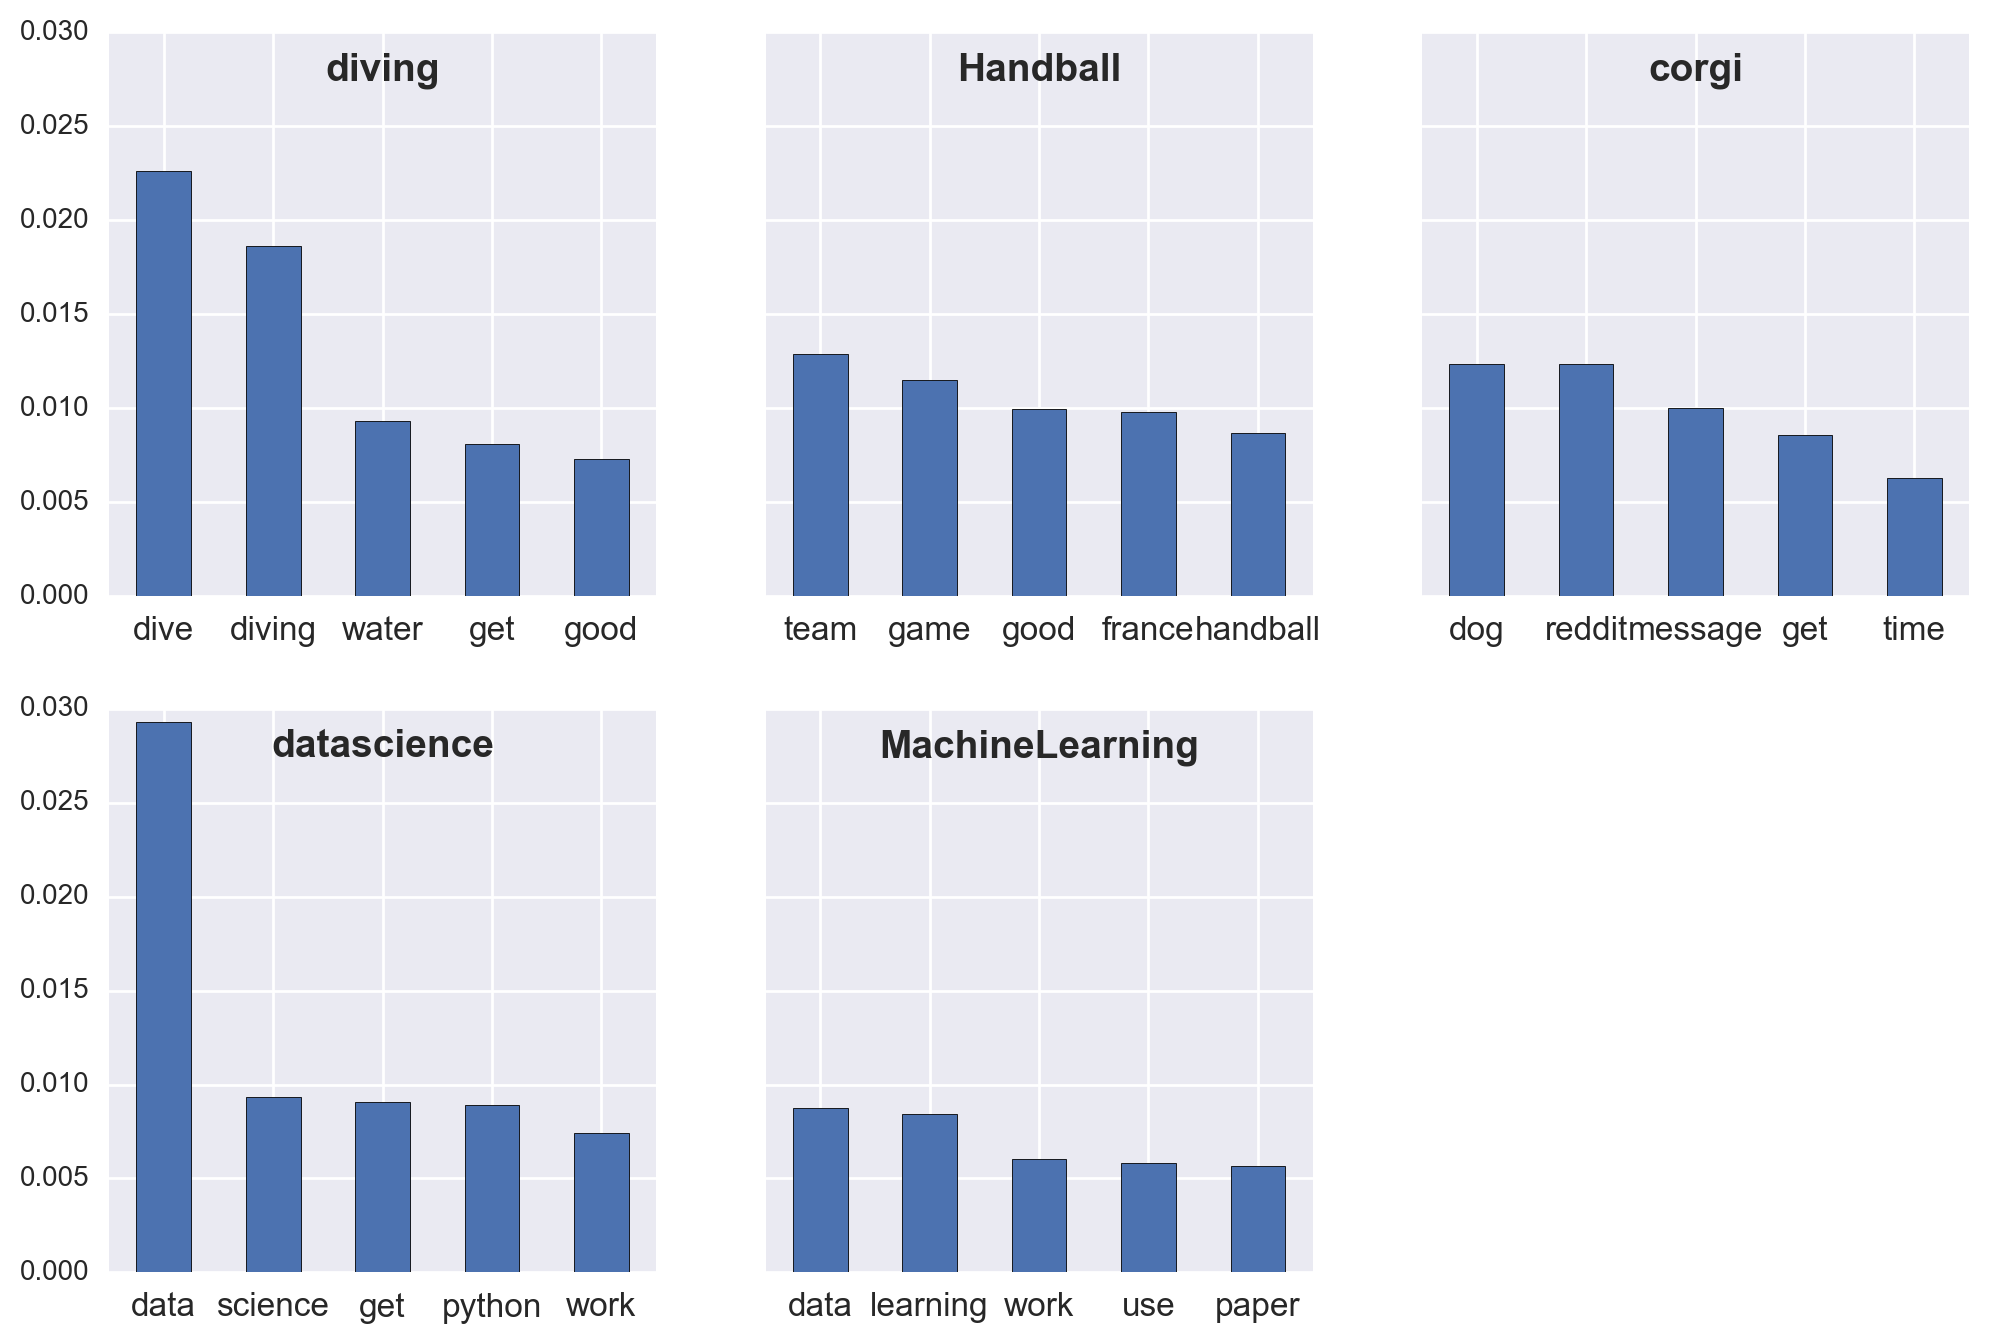

In [21]:
fig, axes = plt.subplots(2, 3, sharex = False, sharey = True, figsize = (12, 8))
cnt = 0
for i in range(2):
    for j in range(3):
        if cnt <= 4:
            rel_freq_list[cnt][:5].plot.bar(ax = axes[i, j])
            axes[i, j].set_xticklabels(rel_freq_list[cnt][:5].index.tolist(), rotation = 0, fontsize = 12)
            axes[i, j].set_xlabel("", fontsize = 12)
            axes[i, j].text(0.5, 0.915, all_subreddit_names[cnt], fontweight = "bold", fontsize = 14, 
                            horizontalalignment = 'center', transform = axes[i, j].transAxes)
            cnt = cnt + 1
        else: 
            axes[i, j].axis('off')

In [22]:
fig.savefig('frequencies.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

---

# <span name="wmd">4. Apply modified WMD to validation sets</span>

The function that gives the modified WMD distance between the input and a channel's representative message:

In [23]:
def wmd_mod(s1, i_cat, no_top):
    """
    s1 is the input document or message
    i_cat denotes which category we are focusing on
    no_top means how many words are included in the representative message
    """ 
    # Representative message made up of no_top top words:
    s2 = " ".join(rel_freq_list[i_cat].index.tolist()[:no_top])  # .split()
    vect_fit = vectorizer.fit([s1, s2])
    # two vectors?
    spacy_words = nlp(" ".join(vect_fit.get_feature_names()))
    # the parameters are two messages and the outputs are two vectors?
    # Make bag-of-words vectors
    v_1, v_2 = vect_fit.transform([s1, s2])
    v_1 = v_1.toarray().ravel().astype(np.double)
    # v_1 is the counts of words appearing in the input message
    v_2 = v_2.toarray().ravel().astype(np.double)
    # here v_2 is just place holder
    # For the representative message, get weights from word distributions:
    for i_s in range(len(v_2)):
        if str(spacy_words[i_s]) in rel_freq_list[i_cat][:no_top]:
            v_2[i_s] = rel_freq_list[i_cat][str(spacy_words[i_s])]
        else: 
            v_2[i_s] = 0
        # the real values of v_2
    v_1 /= v_1.sum()
    v_2 /= v_2.sum()    
    w2v_vectors = [w.vector for w in spacy_words]
    # w is a tuple or list with two elements? w2v_vectors is a list of two vectors?
    dist_matrix = euclidean_distances(w2v_vectors).astype(np.double)
    # print dist_matrix.shape  # too many prints in the application later
    return emd(v_1, v_2, dist_matrix)

Define the full validation set:

In [24]:
valid_full = []
valid_true_labels = []
cnt = 0
for datum in data_valid:
    valid_full = valid_full + datum
    valid_true_labels = valid_true_labels + [all_subreddit_names[cnt]] * len(datum)
    # valid_true_labels is used to evaluate the validation results
    cnt = cnt + 1
len(valid_full)

1945

Define the grid over which we'll search for the optimal number of top words:

In [25]:
top_words_list = range(10, 200, 10)
print top_words_list

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]


Run the validation loop (could take a few hours due to the size of the validation set and the size of the parameter grid; it seems that we could use a small dataset for the validation, for example, a dataset of 500 samples, the conclusion is the same)

In [26]:
t_start = time.time()
acc_list = []
for no_top in top_words_list:
    valid_predict_labels = []
    print "Working on n_top = " + str(no_top)
    for i_example in range(len(valid_full)):
        # Calculate the WMD between message and each channels and find the shortest one
        wmd_avgs = [wmd_mod(valid_full[i_example], i, no_top) for i in range(len(data_valid))]
        index_min = wmd_avgs.index(min(wmd_avgs))
        valid_predict_labels = valid_predict_labels + [all_subreddit_names[index_min]]
        # Monitor progress:
        output_string = "\rExample " + str(i_example + 1) + " / " + str(len(valid_full))
        # here the effect of \r is different from \n
        sys.stdout.write(output_string)
        sys.stdout.flush()
        # flush() is used to erase the previous output on stdout
    acc_list.append(accuracy_score(valid_true_labels, valid_predict_labels))
    print ""   
t_end = time.time()

Working on n_top = 10
Example 1945 / 1945
Working on n_top = 20
Example 1945 / 1945
Working on n_top = 30
Example 1945 / 1945
Working on n_top = 40
Example 1945 / 1945
Working on n_top = 50
Example 1945 / 1945
Working on n_top = 60
Example 1945 / 1945
Working on n_top = 70
Example 1945 / 1945
Working on n_top = 80
Example 1945 / 1945
Working on n_top = 90
Example 1945 / 1945
Working on n_top = 100
Example 1945 / 1945
Working on n_top = 110
Example 1945 / 1945
Working on n_top = 120
Example 1945 / 1945
Working on n_top = 130
Example 1945 / 1945
Working on n_top = 140
Example 1945 / 1945
Working on n_top = 150
Example 1945 / 1945
Working on n_top = 160
Example 1945 / 1945
Working on n_top = 170
Example 1945 / 1945
Working on n_top = 180
Example 1945 / 1945
Working on n_top = 190
Example 1945 / 1945


Plot the validation set accuracy vs. number of top words considered:

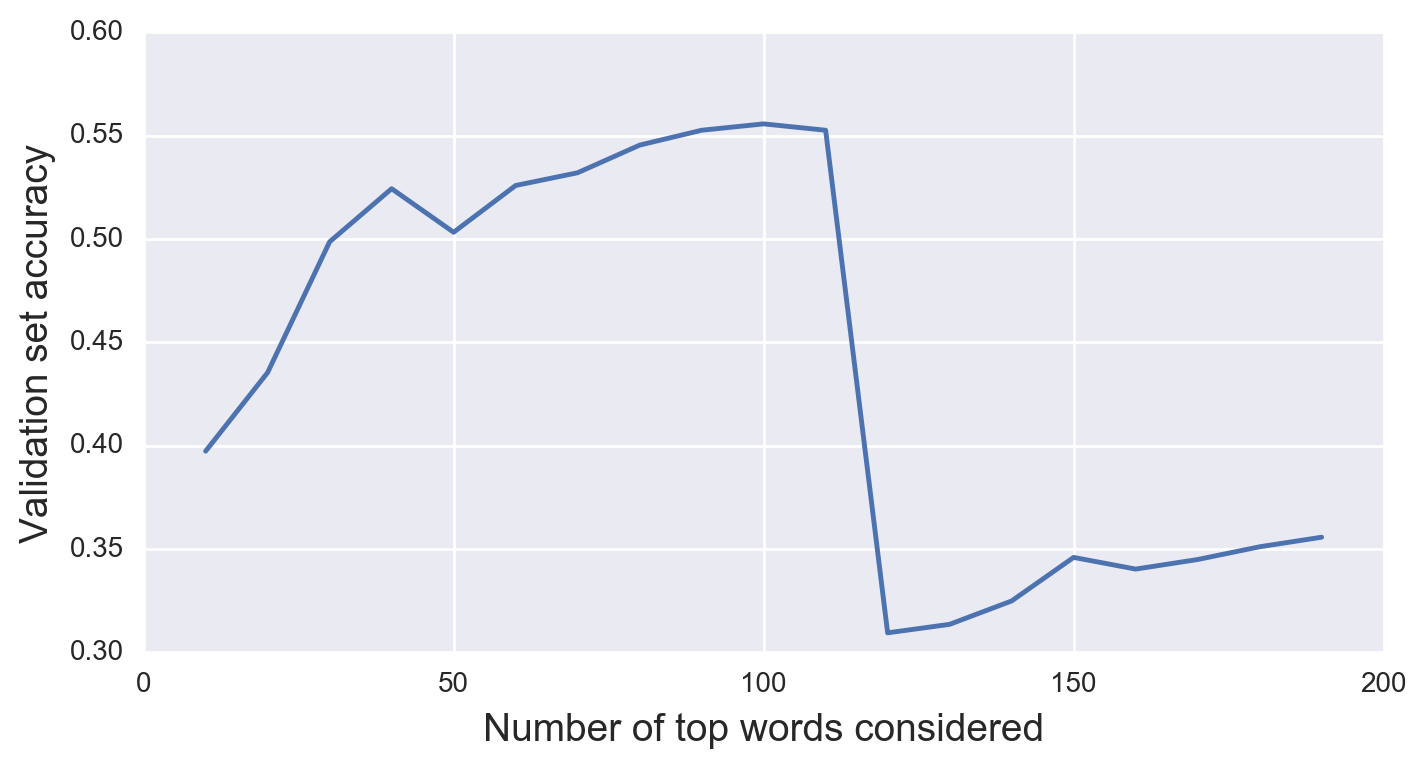

In [27]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(top_words_list, acc_list)
ax.set_xlabel("Number of top words considered", fontsize = 14)
ax.set_ylabel('Validation set accuracy', fontsize = 14);

Optimal number of top words:

In [28]:
no_top_optimal = top_words_list[acc_list.index(max(acc_list))]
no_top_optimal
# very robust result no matter 500 or 5000 examples for each category

100

---

#  <span id="test">5. Accuracy on the test set</span>

Here we'll use the model with optimal number of top words on the test set:

In [29]:
test_full = []
test_true_labels = []
cnt = 0
for datum in data_test:
    test_full = test_full + datum
    test_true_labels = test_true_labels + [all_subreddit_names[cnt]] * len(datum)
    cnt = cnt + 1
len(test_full)

1000

Find the accuracy (same code as used before in the validation loop):

In [30]:
test_predict_labels = []
for i_example in range(len(test_full)):
    wmd_avgs = [wmd_mod(test_full[i_example], i, no_top_optimal) for i in range(len(data_test))]
    index_min = wmd_avgs.index(min(wmd_avgs))
    test_predict_labels = test_predict_labels + [all_subreddit_names[index_min]]
    output_string = "\rExample " + str(i_example + 1) + " / " + str(len(test_full))
    sys.stdout.write(output_string)
    sys.stdout.flush()
test_acc = accuracy_score(test_true_labels, test_predict_labels)
test_acc
# sample size 500 is not enough, 5000 could be better?

Example 1000 / 1000

0.53800000000000003

Add the empty examples to get the effective accuracy (In situations when user will give each document a category):

In [31]:
test_eff_predict_labels = test_predict_labels
for i_example in range(len(test_full)):
    if len(test_full[i_example]) == 0 and test_true_labels[i_example] != test_predict_labels[i_example]: 
        test_eff_predict_labels[i_example] = test_true_labels[i_example]
        # We assume the prediction is right if the input example is empty
        # the right way should be get rid of the empty examples from 
        # both the predict labels and the true labels

In [32]:
test_eff_acc = accuracy_score(test_true_labels, test_eff_predict_labels)
test_eff_acc

0.56200000000000006

Remove the empty examles from both predict labels and true labels (In situations when the algorithm has to give each document a category):

In [33]:
test_eff_predict_labels = test_predict_labels
for i_example in range(len(test_full)):
    if len(test_full[i_example]) == 0:
        del test_eff_predict_labels[i_example]
        del test_true_labels[i_example]
print '# of predicted lables: ' + str(len(test_eff_predict_labels))
print '# of true lables: ' + str(len(test_true_labels))

# of predicted lables: 975
# of true lables: 975


In [34]:
test_eff_acc = accuracy_score(test_true_labels, test_eff_predict_labels)
test_eff_acc

0.56205128205128208

Let's look at the confusion matrix:

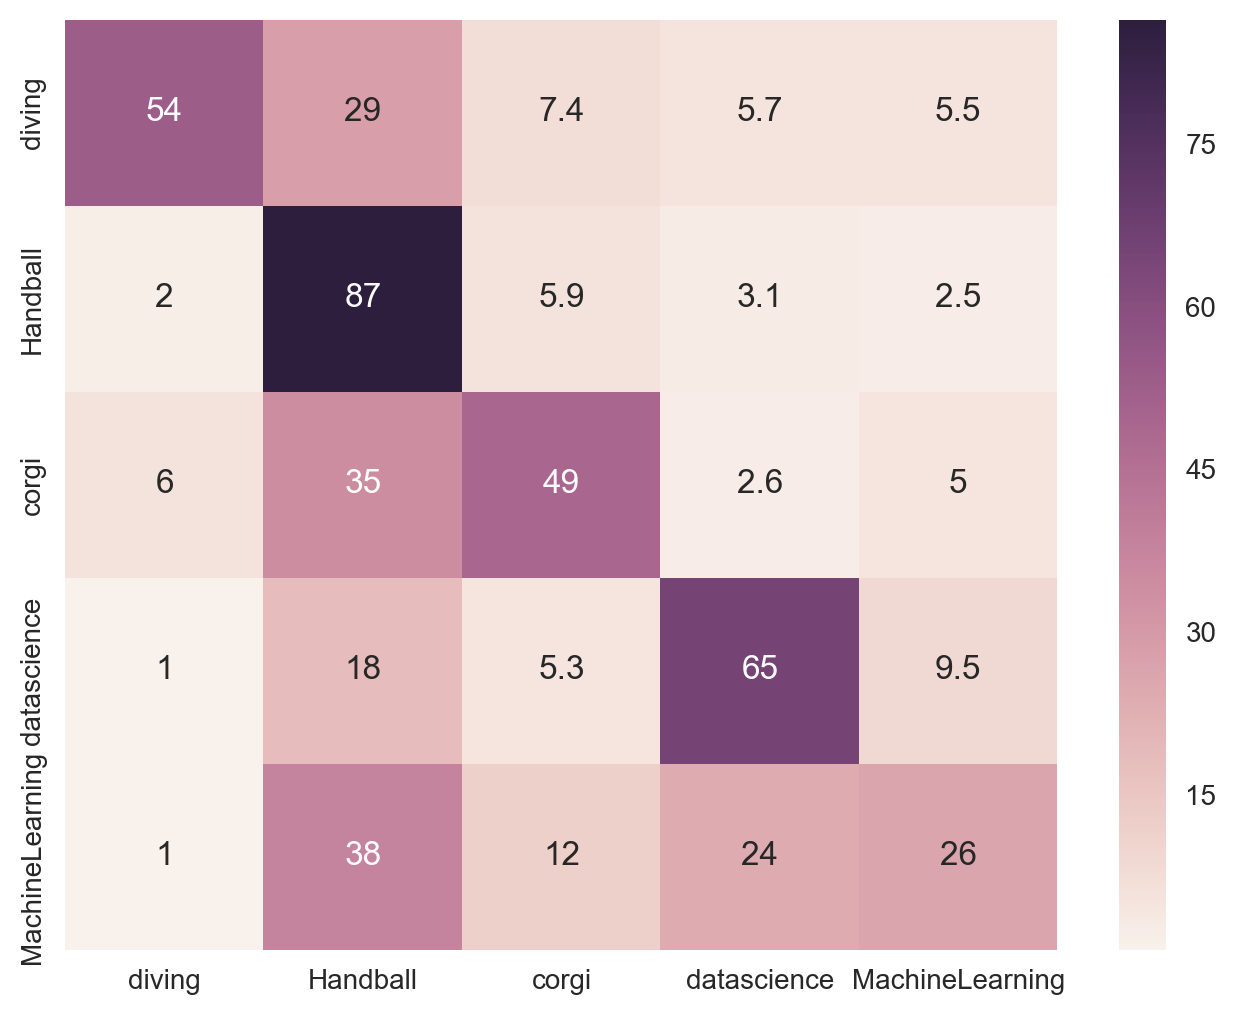

In [35]:
conf_mat = confusion_matrix(test_true_labels, test_eff_predict_labels, labels = all_subreddit_names)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis = 1)
conf_df = pd.DataFrame(conf_mat * 100, index = all_subreddit_names, columns = all_subreddit_names)
fig, ax = plt.subplots(figsize = (8, 6))
seaborn.heatmap(conf_df, annot = True, ax = ax);
# the vertical labels are true labels, and the horizontal labels are predicted labels

In [36]:
fig.savefig('confusion_matrix.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

---

# <a name="thresh">6. Implementing a threshold</a>

Let's look at the examples we got wrong and their corresponding scores. First we extract all the scores and then look at the examples we got wrong in a dataframe:

In [37]:
optimal_scores = [[wmd_mod(example, i, no_top_optimal) 
                   for example in test_full] 
                  for i in range(len(data_test))]

In [38]:
# just to check the calculation of optimal_scores, the same test_acc proves the right calculation
test_predict_labels = []
for i_example in range(len(test_full)):
    wmd_avgs = [optimal_scores[i][i_example] for i in range(len(data_test))]
    index_min = wmd_avgs.index(min(wmd_avgs))
    test_predict_labels = test_predict_labels + [all_subreddit_names[index_min]]
test_acc = accuracy_score(test_true_labels, test_predict_labels)
test_acc

ValueError: Found arrays with inconsistent numbers of samples: [ 975 1000]

In [33]:
outcome_df = pd.DataFrame({"post":test_full, "true":test_true_labels, "prediction":test_predict_labels,
                          all_subreddit_names[0]: optimal_scores[0], all_subreddit_names[1]: optimal_scores[1],
                          all_subreddit_names[2]: optimal_scores[2],all_subreddit_names[3]: optimal_scores[3],
                          all_subreddit_names[4]: optimal_scores[4]},
                          columns = ["post", "true",  "prediction", all_subreddit_names[0],all_subreddit_names[1],
                                    all_subreddit_names[2], all_subreddit_names[3], all_subreddit_names[4]])

In [34]:
outcome_df[outcome_df['true'] != outcome_df['prediction']].head(10)

,post,true,prediction,diving,Handball,corgi,datascience,MachineLearning
1,going use anything special,diving,MachineLearning,5.648222,5.960952,5.854763,5.559248,5.539884
2,love rex,diving,corgi,7.197300,7.309761,6.879345,7.355230,7.312234
3,nice love,diving,corgi,6.436094,6.700673,6.279668,6.717220,6.649892
6,nose blocking device regulator attaches padded...,diving,MachineLearning,7.618587,7.847395,7.682667,7.637739,7.544745
10,ahh saw picture phone thought enjoy new hat,diving,corgi,6.411407,6.501221,6.284406,6.495543,6.405297
11,sho nuff,diving,corgi,7.655625,7.716720,7.538473,7.864629,7.804031
18,scuba report problem reddit delete comment www...,diving,MachineLearning,7.188408,7.480170,7.409891,6.986196,6.871748
22,deleted,diving,MachineLearning,8.614324,8.636308,8.549680,8.371519,8.351423
24,add swallowing moving jaw successful ears coup...,diving,MachineLearning,6.195571,6.446468,6.295009,6.218523,6.109035
27,similar issue started problem eustachian tubes...,diving,MachineLearning,6.393441,6.673910,6.566191,6.502599,6.269727


As we can see, a lot of these comments are in fact generic, and could belong to any category. In fact, our model picked up on that: the scores are somewhat close together. 

Let's try to filter out some of these by introducing a threshold. If the relative difference between the highest and the lowest score is smaller than some $\epsilon$, we'll flag those messages as generic. Let's loop over some range of $\epsilon$ and record the proportions of correctly classified examples flagged as generic and the incorrectly classified examples flagged as non-generic:

In [47]:
list2 = []
list3 = []
thresh_list = np.linspace(0.001,0.1,100)
for thresh in thresh_list:
    predicted_labels = []
    generic = []
    for i_test in range(len(test_full)):
        # Get the scores for this test example from before
        scores_local = [optimal_scores[i][i_test] for i in range(len(data_test))]
        index_min = scores_local.index(min(scores_local))
        top_indices = np.argsort(scores_local)
        # Compare the lowest and highest score
        top_score = scores_local[top_indices[0]]
        next_score = scores_local[top_indices[4]]
        rel_diff = np.abs(top_score - next_score) / top_score
        predicted_labels.append(all_subreddit_names[index_min])
        if rel_diff > thresh: generic.append(False)
        else: generic.append(True)
    count2 = 0
    count3 = 0
    # Calculate those proportions
    for i in range(len(test_full)):
        if test_true_labels[i] == predicted_labels[i] and generic[i] == True: count2 = count2 + 1
        if test_true_labels[i] != predicted_labels[i] and generic[i] == False: count3 = count3 + 1
    list2.append(count2 / len(test_full))
    list3.append(count3 / len(test_full))

Let's plot these proportions:

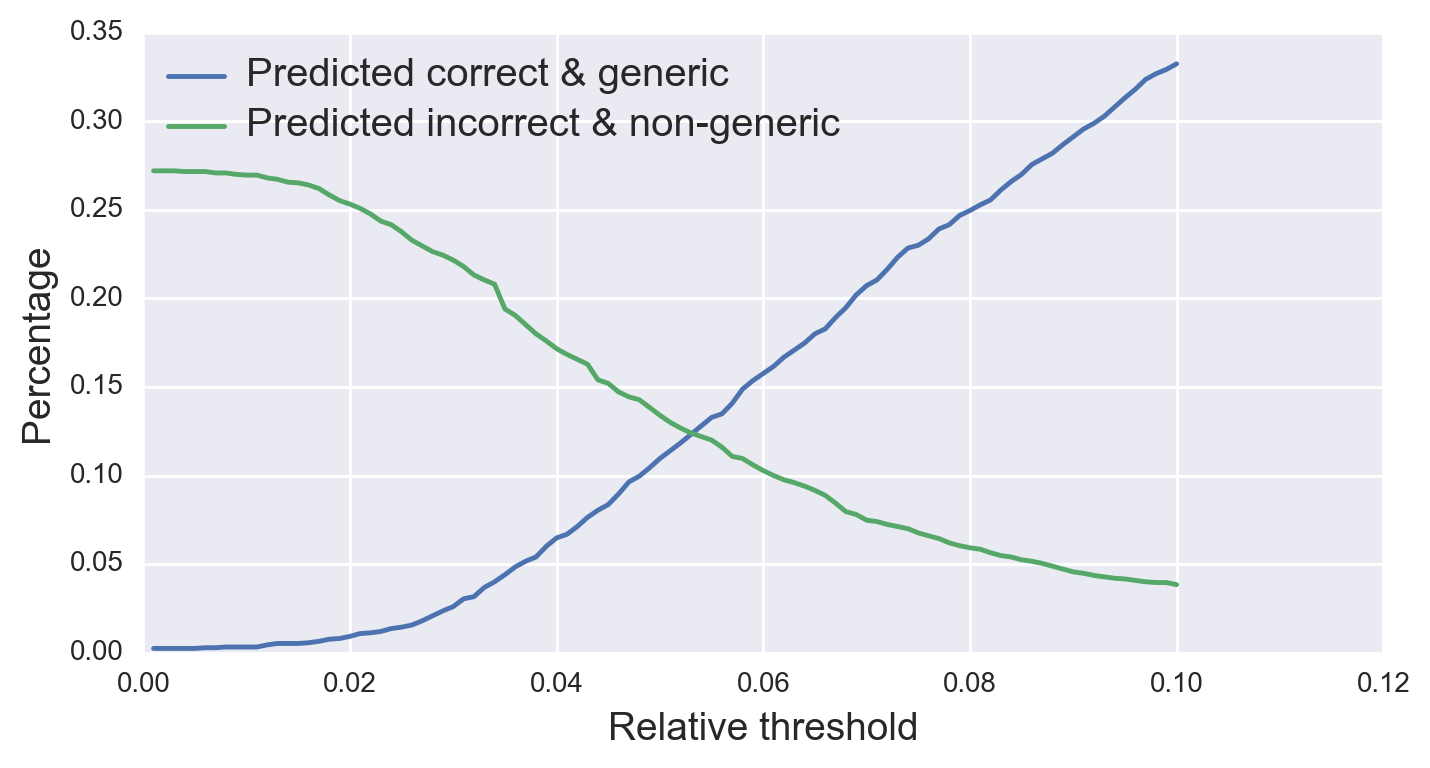

In [101]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(thresh_list, list2, label = "Predicted correct & generic")
ax.plot(thresh_list, list3, label = "Predicted incorrect & non-generic")
ax.set_xlabel("Relative threshold", fontsize = 14)
ax.set_ylabel('Percentage', fontsize = 14)
legend = ax.legend(loc='upper left');
for label in legend.get_texts():
    label.set_fontsize('large')

In [102]:
fig.savefig('threshold.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

See the blog for more explanation on these, but the idea now is that:
* We would like to minimize the number of correctly classified messages that are flagged as generic, as flagging a message as generic introduces a possibility that we mis-flagged it, which would decrease the accuracy of the model. 
* On the other hand, in order to try to increase the accuracy of our model, we would like to maximize the number of incorrectly classified messages flagged as generic, as flagging a message as generic also introduces a possibility that we correctly flagged it, which would increase the accuracy of the model. 
* As we increase the threshold, the amount of correctly classified messages predicted to be generic will increase, while the amount of the incorrectly classified messages predicted to be non-generic will decrease, as shown in the plot above. 

A natural choice for the optimal threshold is the place where the two curves intersect, which is about 0.05 in our case.

In [49]:
arg_cross = np.argwhere(np.diff(np.sign(np.array(list2) - np.array(list3))) != 0)[0, 0]

In [50]:
thresh_opt = (thresh_list[arg_cross] + thresh_list[arg_cross + 1]) / 2
thresh_opt

0.053500000000000006

For this value of the threshold, let's flag the generic posts:

In [51]:
predicted_labels = []
generic = []
for i_test in range(len(test_full)):
    scores_local = [optimal_scores[i][i_test] for i in range(len(data_test))]
    index_min = scores_local.index(min(scores_local))
    top_indices = np.argsort(scores_local)
    top_score = scores_local[top_indices[0]]
    next_score = scores_local[top_indices[4]]
    rel_diff = np.abs(top_score - next_score) / top_score
    predicted_labels.append(all_subreddit_names[index_min])
    if rel_diff > thresh_opt: generic.append(False)
    else: generic.append(True)

Now we need to manually inspect all the posts that have been flagged as generic: the truly generic missclassified posts will then positively contribute to our overall accuracy, and the falsely generic, but correctly classified ones will contribute negatively:

In [54]:
generic_class = []
generic_misclass = []
for i_test in range(len(test_full)):
    if generic[i_test] == True and predicted_labels[i_test] != test_true_labels[i_test]:
        generic_misclass.append(test_full[i_test])
    if generic[i_test] == True and predicted_labels[i_test] == test_true_labels[i_test]:
        generic_class.append(test_full[i_test])

In [88]:
generic_class_clean = [g for g in generic_class if len(g) > 0]
generic_misclass_clean = [g for g in generic_misclass if len(g) > 0]
print "Number of correctly classified examples flagged as generic: ", len(generic_class_clean)
print "Number of incorrectly classified examples flagged as generic: ", len(generic_misclass_clean)

Number of correctly classified examples flagged as generic:  306
Number of incorrectly classified examples flagged as generic:  372


After manually inspecting the above, I found that:
* Only 31 of the correctly classified examples were falsely flagged as generic.
* Only 12 of the incorrectly classified examples were falsely flagged as generic.

In [95]:
false_generics_correct = 31
false_generics_mislass = 12

Hence, the final accuracy of our model is:

In [97]:
extra_corrects = len(generic_misclass_clean) - false_generics_mislass - false_generics_correct

In [99]:
(test_eff_acc * len(test_full) + extra_corrects) / len(test_full)

0.8596